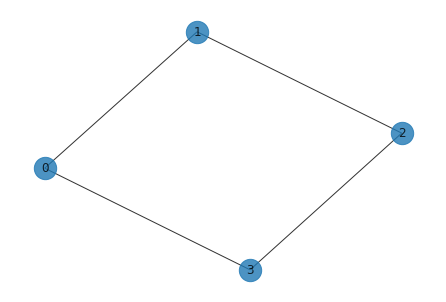

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

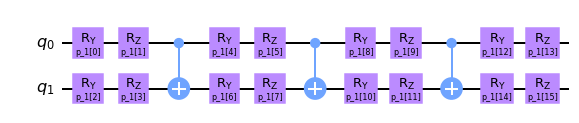

In [2]:
repeat = 4

qc_u1 = QuantumCircuit(2)
pv_u1 = ParameterVector('p_1', 4*repeat)

t = 0
for i in range(repeat):   
    qc_u1.ry(pv_u1[t], 0)
    qc_u1.rz(pv_u1[t+1],0)
    qc_u1.ry(pv_u1[t+2], 1)
    qc_u1.rz(pv_u1[t+3], 1)
    if i < repeat-1: qc_u1.cnot(0,1)
    t += 4

qc_u1.draw(output="mpl")

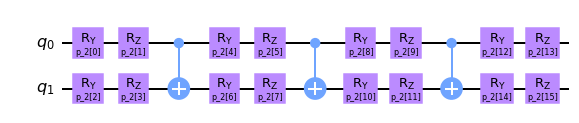

In [3]:
qc_u2 = QuantumCircuit(2)
pv_u2 = ParameterVector('p_2', 4*repeat)

t = 0
for i in range(repeat):   
    qc_u2.ry(pv_u2[t], 0)
    qc_u2.rz(pv_u2[t+1],0)
    qc_u2.ry(pv_u2[t+2], 1)
    qc_u2.rz(pv_u2[t+3], 1)
    if i < repeat-1: qc_u2.cnot(0,1)
    t += 4

qc_u2.draw(output="mpl")

In [4]:
def create_circ(G, theta):
    
    qc = QuantumCircuit(4)
    qc.h(range(4))
    
    r = 4
    pv = ParameterVector('p', 2*4*r)
    
    t = 0
    for i in range(r):   
        qc.ry(theta[t], 0)
        qc.rz(theta[t+1],0)
        qc.ry(theta[t+2], 1)
        qc.rz(theta[t+3], 1)
        if i < r-1: qc.cnot(0,1)
        t += 4

    t = int(len(theta)/2)
    for i in range(r):   
        qc.ry(theta[t], 2)
        qc.rz(theta[t+1],2)
        qc.ry(theta[t+2], 3)
        qc.rz(theta[t+3], 3)
        if i < r-1: qc.cnot(2,3)
        t += 4
    
    qc.measure_all()
    return qc
    
# qc.measure_all()

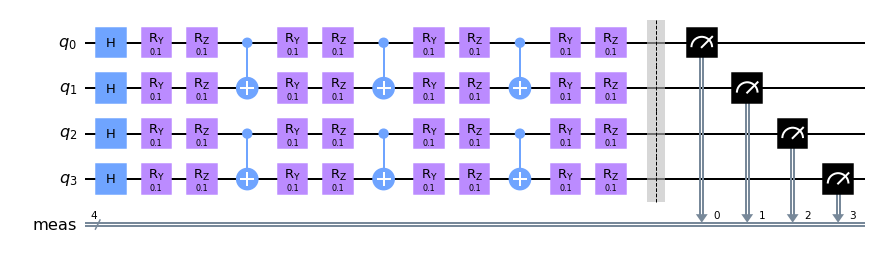

In [5]:
para = []
repeat = 4
for i in range(repeat*2*4): para.append(0.1)

qc_test = create_circ(G, para)

qc_test.draw(output="mpl")

In [6]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

maxcut_obj([0,1,1,0], G)

def compute_expectation(counts, G):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(G, p, shots=1024):
     
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=1024).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [7]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=1)
res = minimize(expectation, 
              para, 
              method='COBYLA')
res

     fun: -3.974609375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 330
  status: 1
 success: True
       x: array([ 1.18787427,  1.27124544, -0.20255733, -0.05441321,  0.54320018,
        0.90227595, -0.41350104, -0.01398469, -0.56088696,  1.16411682,
        1.2100077 ,  0.01888939,  0.03449294,  0.26004768, -0.13267734,
       -0.19479047,  1.70770001,  0.00470057,  0.25331133,  1.13444766,
       -0.11086698,  1.6327909 , -0.40892292,  0.05997362, -0.19848839,
        0.63149886,  0.30908635,  1.68176574, -0.2145364 ,  0.06012667,
        1.00068309,  0.2019374 ])

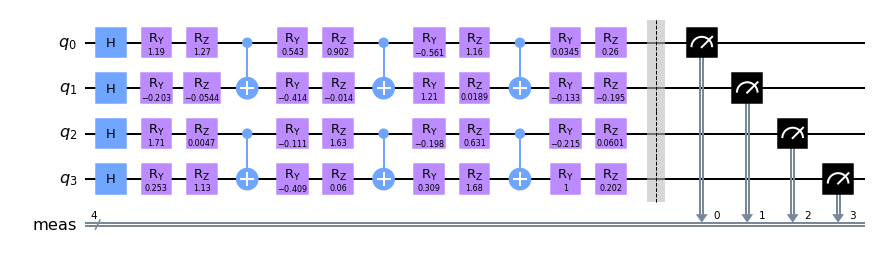

In [8]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 8*1024

qc_res = create_circ(G, res.x)

qc_res.draw(output="mpl")

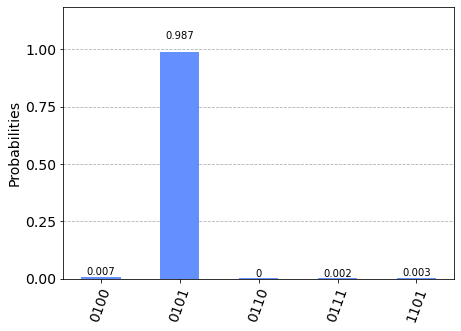

In [9]:
result = backend.run(qc_res, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

#### Parameterized unitary $U_1$

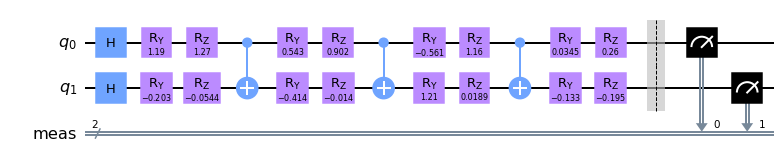

In [10]:
repeat = 4

qc_u1 = QuantumCircuit(2)
qc_u1.h(range(2))

t = 0
for i in range(repeat):   
    qc_u1.ry(res.x[t], 0)
    qc_u1.rz(res.x[t+1],0)
    qc_u1.ry(res.x[t+2], 1)
    qc_u1.rz(res.x[t+3], 1)
    if i < repeat-1: qc_u1.cnot(0,1)
    t += 4
qc_u1.measure_all()
qc_u1.draw(output="mpl")

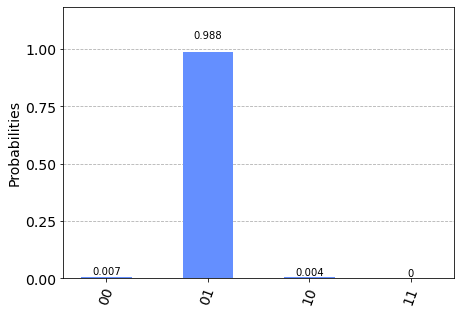

In [11]:
result = backend.run(qc_u1, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

#### Parameterized unitary $U_2$

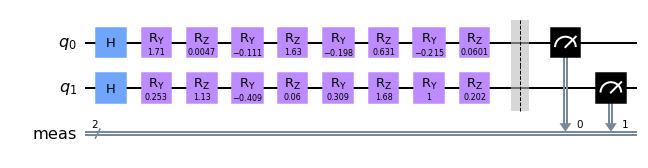

In [12]:
repeat = 4

qc_u2 = QuantumCircuit(2)
qc_u2.h(range(2))

t = int(len(res.x)/2)
for i in range(repeat):   
    qc_u2.ry(res.x[t], 0)
    qc_u2.rz(res.x[t+1],0)
    qc_u2.ry(res.x[t+2], 1)
    qc_u2.rz(res.x[t+3], 1)
    if i < repeat-1: qc_u1.cnot(0,1)
    t += 4
qc_u2.measure_all()
qc_u2.draw(output="mpl")

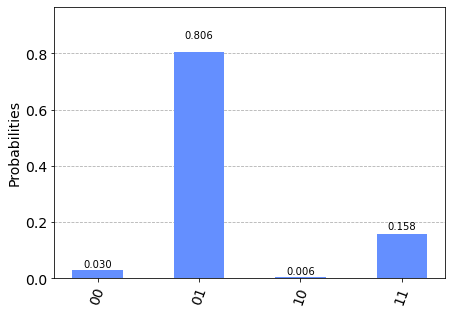

In [13]:
result = backend.run(qc_u2, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)